In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats


In [2]:
data = pd.read_csv("winemag-data-130k-v2.csv")

In [3]:
df = data[[ 'country', 'description', 'designation', 'points', 'price', 'province', 'title', 'variety', 'winery']]
df.to_csv('wine.csv',index=False)
dataNew = pd.read_csv("wine.csv")


In [4]:
def isSpain(x):
    if type(x)==str:
        return  ('Spain' in x)             
    return False
SP = dataNew.groupby(dataNew.apply(lambda x: isSpain(x['country']) ,axis=1))
spa = SP.get_group(True)
spa=spa.dropna(axis=0)
spa.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'title', 'variety', 'winery'],
      dtype='object')

In [5]:
spa.head(7)

,country,description,designation,points,price,province,title,variety,winery
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
18,Spain,"Desiccated blackberry, leather, charred wood a...",Vendimia Seleccionada Finca Valdelayegua Singl...,87,28.0,Northern Spain,Pradorey 2010 Vendimia Seleccionada Finca Vald...,Tempranillo Blend,Pradorey
154,Spain,"Ripe aromas of raisin, black plum and horsehid...",Single Vineyard Estate Bottled,91,50.0,Central Spain,Marques de Griñon 2010 Single Vineyard Estate ...,Graciano,Marques de Griñon
212,Spain,Mellow white-fruit aromas are nonspecific and ...,Fermentado en Barrica,90,40.0,Northern Spain,Matarromera 2015 Fermentado en Barrica Verdejo...,Verdejo,Matarromera
244,Spain,Simple but well-maded wine with aromas of chew...,Herederos de François Lurton Villafrance de Duero,85,13.0,Northern Spain,J. & F. Lurton 2007 Herederos de François Lurt...,Red Blend,J. & F. Lurton
287,Spain,This is the stud in the Acústic stable. A blen...,Braó Vinyes Velles,92,40.0,Catalonia,Acústic 2010 Braó Vinyes Velles Carignan-Grena...,Carignan-Grenache,Acústic
339,Spain,"Red in color, with berry and apple aromas, thi...",1887 Rosado,82,13.0,Catalonia,Cavas Hill NV 1887 Rosado Sparkling (Cava),Sparkling Blend,Cavas Hill


In [6]:
def raspredelyaem(x):
    if x <= 15:
        return 'price <= 15'
    if 15<x and x<=30:
        return '15 < price <= 30'
    if 30<x and x<=45:
        return '30 < price <= 45'
    else:
        return 'unknown'
spa['priceCategory'] = spa["price"].apply(lambda x : raspredelyaem(x))
spa = spa.loc[spa['priceCategory'] != 'unknown']

In [7]:
spa['pointsbyprice']= spa.apply(lambda x: x['points']/(10+np.log( x['price'])), axis=1)

In [8]:
spa.groupby('priceCategory').groups

{'15 < price <= 30': Int64Index([    18,    426,    490,    496,    635,    680,    809,    943,
                952,    958,
             ...
             129498, 129588, 129693, 129727, 129737, 129776, 129789, 129799,
             129930, 129957],
            dtype='int64', length=1992),
 '30 < price <= 45': Int64Index([   212,    287,    439,    604,    881,   1323,   1326,   1782,
               2175,   2179,
             ...
             128552, 128766, 128789, 128827, 129297, 129497, 129509, 129655,
             129884, 129902],
            dtype='int64', length=638),
 'price <= 15': Int64Index([     5,    244,    339,    438,    500,    667,    762,    763,
                820,    821,
             ...
             129178, 129182, 129187, 129197, 129204, 129356, 129359, 129390,
             129606, 129856],
            dtype='int64', length=1887)}

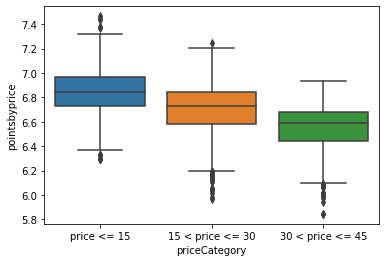

In [9]:
sns.boxplot( y=spa['pointsbyprice'], x=spa['priceCategory'] );
plt.show()

Видим, что вино в третьей ценовой категории выделяется

In [10]:
stats.levene(spa['pointsbyprice'][spa['priceCategory'] == 'price <= 15'],
             spa['pointsbyprice'][spa['priceCategory'] == '15 < price <= 30'],
             spa['pointsbyprice'][spa['priceCategory'] == '30 < price <= 45'])

LeveneResult(statistic=0.8221069839475049, pvalue=0.43957044291836445)

Принимаем равенство дисперсий

Проверяем выборки на нормальность


In [11]:
stats.shapiro(spa['pointsbyprice'][spa['priceCategory'] == 'price <= 15'])

(0.9945544004440308, 2.1056432615296217e-06)

In [12]:
stats.shapiro(spa['pointsbyprice'][spa['priceCategory'] == '15 < price <= 30'])

(0.9769976735115051, 2.2393003409117038e-17)

In [13]:
stats.shapiro(spa['pointsbyprice'][spa['priceCategory'] == '30 < price <= 45'])

(0.9448378682136536, 1.1525931373061217e-14)

Выборки не нормальны. Проведём Краскел-Тест

In [14]:
stats.kruskal(spa['pointsbyprice'][spa['priceCategory'] == 'price <= 15'],
             spa['pointsbyprice'][spa['priceCategory'] == '15 < price <= 30'],
             spa['pointsbyprice'][spa['priceCategory'] == '30 < price <= 45'])

KruskalResult(statistic=986.5545502401163, pvalue=5.92108597420759e-215)

Отвергаем гипотезу о равенстве средних, поскольку p-value меньше 0.05

In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=spa['pointsbyprice'], groups=spa['priceCategory'], alpha=0.05)
print(m_comp)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
15 < price <= 30 30 < price <= 45  -0.1496 0.001 -0.1696 -0.1296   True
15 < price <= 30      price <= 15   0.1397 0.001  0.1256  0.1538   True
30 < price <= 45      price <= 15   0.2893 0.001  0.2692  0.3094   True
-----------------------------------------------------------------------


In [16]:
pip install scikit_posthocs

Note: you may need to restart the kernel to use updated packages.


In [17]:
import scikit_posthocs as spp

In [18]:
spp.posthoc_dunn([spa['pointsbyprice'][spa['priceCategory'] == 'price <= 15'],
             spa['pointsbyprice'][spa['priceCategory'] == '15 < price <= 30'],
             spa['pointsbyprice'][spa['priceCategory'] == '30 < price <= 45']], 
                 p_adjust='fdr_bh')

,1,2,3
1,-1.000000e+00,1.485289e-92,2.719241e-192
2,1.485289e-92,-1.000000e+00,1.845657e-53
3,2.719241e-192,1.845657e-53,-1.000000e+00


В итоге имеем: Категория цены от 30 до 45 имеет худшее соотношение цена-качество, что и подтверждается "Ящиком с усами"

Получается, что третья категория самая "Неудачная" для испанского вина среди остальных двух категорий, оставшиеся же примерно одинаковы